# Import Packages

In [1]:
"""
Main File for QRT - Electricity Price - 2023 Project
"""
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split

from scipy.stats import spearmanr

from xgboost import XGBRegressor

# Data Preprocessing

In [2]:
# Importing Data From Files
curr_dir = '/Users/talhajamal/Desktop/Code/Python_Projects/QRT - 2023 - Electricity Price/'
os.chdir(curr_dir)

X = pd.read_csv(f"{curr_dir}data/X_train_NHkHMNU.csv").set_index('ID').sort_index()
y = pd.read_csv(f"{curr_dir}data/y_train_ZAN5mwg.csv").set_index('ID').sort_index()
x_validation = pd.read_csv(f"{curr_dir}data/X_test_final.csv").set_index('ID')

# Useful Functions

In [3]:
def plot_ts(ts: pd.Series, title: str = None, figsize=(13,5)) -> None:
    """plots a given timeseries and displays an optional title"""
    plt.figure(figsize=figsize)
    ax = plt.subplot(111)
    plt.plot(ts)
    plt.title(title or '', fontsize=10)
    plt.grid(alpha=0.5, linestyle='dashed')
    plt.show()

# Split Data

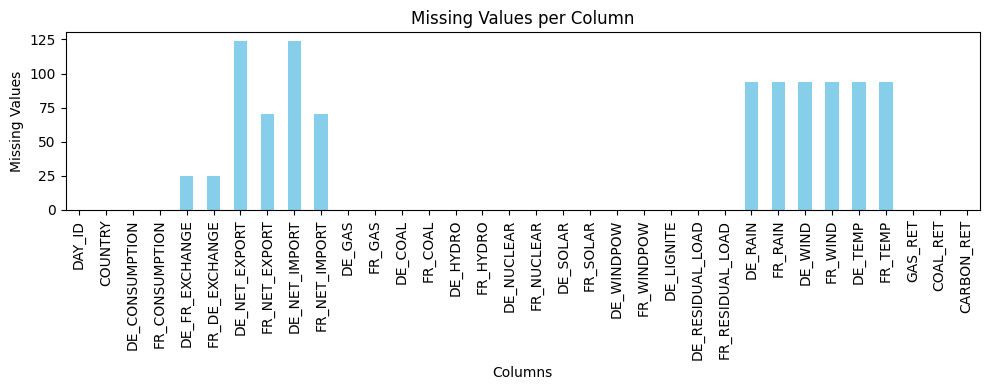

In [4]:
missing_values = X.isna().sum()
missing_values.plot(kind='bar', figsize=(10, 4), color='skyblue')
plt.title('Missing Values per Column')
plt.xlabel('Columns')
plt.ylabel('Missing Values')
plt.xticks(rotation=90)  # Rotate the x labels to show them vertically
plt.tight_layout()  # Adjust layout to make room for the x labels
plt.show()

# Fill Data

In [5]:
# Fill Missing Data
X = X.interpolate(method='polynomial', order=2)

# Combined Training and Testing Data
#full_data = pd.concat([x_train, x_test], axis=0).sort_index()
#de_full_data = full_data[full_data['COUNTRY'] == 'DE']
#fr_full_data = full_data[full_data['COUNTRY'] == 'FR']

#x_train = x_train.interpolate(method='linear')
#x_test = x_test.interpolate(method='linear')

# Separating data for each country
#de_x_train = x_train[x_train['COUNTRY'] == 'DE']
#de_y_train = y_train[y_train.index.isin(de_x_train.index)]
#fr_x_train = x_train[x_train['COUNTRY'] == 'FR']
#fr_y_train = y_train[y_train.index.isin(fr_x_train.index)]

# XGBoost Regression

In [6]:
X_clean = X.drop(['COUNTRY'], axis=1)
Y_clean = y['TARGET']
xgb = XGBRegressor()
xgb.fit(X_clean, Y_clean)
output_train = xgb.predict(X_clean)

def metric_train(output):
    return  spearmanr(output, Y_clean).correlation

print('Spearman correlation for the train set: {:.1f}%'.format(100 * metric_train(output_train) ))

Spearman correlation for the train set: 72.6%


In [7]:
X_validation_clean = x_validation.drop(['COUNTRY'], axis=1).fillna(0)

Y_test_submission = pd.DataFrame()
Y_test_submission['ID'] = x_validation.index.to_list()
Y_test_submission['TARGET'] = xgb.predict(X_validation_clean)

Y_test_submission.to_csv('src/xgb_predictions.csv', index=False)

In [8]:
Y_test_submission

,ID,TARGET
0,1115,-0.272144
1,1202,-0.096273
2,1194,-0.184181
3,1084,0.015469
4,1135,-0.258083
...,...,...
649,879,-0.808060
650,673,0.276241
651,1641,1.822636
652,712,-0.230851


Current out of sample performance is 18.58%. This beats the benchmark Linear Regression Model's performance of 15.9%